# [LeVIT explanition](https://paperswithcode.com/method/levit)

In [2]:
# !python3 -m pip install --upgrade pip
!python3 -m pip install torchsummary
! pip install lion-pytorch

In [1]:
import logging
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Sampler
from torchvision import transforms
from typing import Callable, Union, Optional, Iterator, Mapping, Sequence, List, Dict, Any, Tuple
import random
import yaml
from torch.nn.functional import layer_norm
from timm.models.layers import trunc_normal_, DropPath


### DATASET

In [2]:
from PIL import Image
import codecs
from torchvision.datasets import VisionDataset


class LangDataset(VisionDataset):
    classes = ["negative", "positive"]  
    
    def __init__(
        self,
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        super().__init__(os.path.dirname(root), transforms, transform, target_transform)
        self.classes2idx = {c: i for i, c in enumerate(self.classes)}
        with codecs.open(root, "r", encoding="utf-8") as file:
            self.data: List[Tuple[str, int]] = []
            for line in file:
                path, label = line.replace("\\", "/").replace("\n", "").rsplit(",", 1)
                self.data.append((os.path.join(self.root, path), int(label)))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.data[index]

        img = Image.open(path).convert("L")
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)

### LeViT

In [3]:
### DATASET# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.

# Modified from
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
# Copyright 2020 Ross Wightman, Apache-2.0 License

import torch
import itertools
# import utils

from timm.models.vision_transformer import trunc_normal_
from timm.models.registry import register_model

specification = {
    'LeViT_128S': {
        'C': '128_256_384', 'D': 16, 'N': '4_6_8', 'X': '2_3_4',
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-128S-96703c44.pth'},
    'LeViT_128': {
        'C': '128_256_384', 'D': 16, 'N': '4_8_12', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-128-b88c2750.pth'},
    'LeViT_192': {
        'C': '192_288_384', 'D': 32, 'N': '3_5_6', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-192-92712e41.pth'},
    'LeViT_256': {
        'C': '256_384_512', 'D': 32, 'N': '4_6_8', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-256-13b5763e.pth'},
    'LeViT_384': {
        'C': '384_512_768', 'D': 32, 'N': '6_9_12', 'X': '4_4_4', 'drop_path': 0.1,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-384-9bdaf2e2.pth'},
}

__all__ = [specification.keys()]


@register_model
def LeViT_128S(num_classes=1000, distillation=True,
               pretrained=False, pretrained_cfg=None, fuse=False, drop_path=0):
    return model_factory(**specification['LeViT_128S'], num_classes=num_classes,
                         distillation=distillation, pretrained=pretrained, fuse=fuse, drop_path=drop_path)


@register_model
def LeViT_128(num_classes=1000, distillation=True,
              pretrained=False, pretrained_cfg=None, fuse=False):
    return model_factory(**specification['LeViT_128'], num_classes=num_classes,
                         distillation=distillation, pretrained=pretrained, fuse=fuse)


@register_model
def LeViT_192(num_classes=1000, distillation=True,
              pretrained=False, pretrained_cfg=None, fuse=False):
    return model_factory(**specification['LeViT_192'], num_classes=num_classes,
                         distillation=distillation, pretrained=pretrained, fuse=fuse)


@register_model
def LeViT_256(num_classes=1000, distillation=True,
              pretrained=False, pretrained_cfg=None, fuse=False):
    return model_factory(**specification['LeViT_256'], num_classes=num_classes,
                         distillation=distillation, pretrained=pretrained, fuse=fuse)


@register_model
def LeViT_384(num_classes=1000, distillation=True,
              pretrained=False, pretrained_cfg=None, fuse=False):
    return model_factory(**specification['LeViT_384'], num_classes=num_classes,
                         distillation=distillation, pretrained=pretrained, fuse=fuse)


FLOPS_COUNTER = 0


class Conv2d_BN(torch.nn.Sequential):
    def __init__(self, a, b, ks=1, stride=1, pad=0, dilation=1,
                 groups=1, bn_weight_init=1, resolution=-10000):
        super().__init__()
        self.add_module('c', torch.nn.Conv2d(
            a, b, ks, stride, pad, dilation, groups, bias=False))
        bn = torch.nn.BatchNorm2d(b)
        torch.nn.init.constant_(bn.weight, bn_weight_init)
        torch.nn.init.constant_(bn.bias, 0)
        self.add_module('bn', bn)

        global FLOPS_COUNTER
        output_points = ((resolution + 2 * pad - dilation *
                          (ks - 1) - 1) // stride + 1)**2
        FLOPS_COUNTER += a * b * output_points * (ks**2) // groups

    @torch.no_grad()
    def fuse(self):
        c, bn = self._modules.values()
        w = bn.weight / (bn.running_var + bn.eps)**0.5
        w = c.weight * w[:, None, None, None]
        b = bn.bias - bn.running_mean * bn.weight / \
            (bn.running_var + bn.eps)**0.5
        m = torch.nn.Conv2d(w.size(1) * self.c.groups, w.size(
            0), w.shape[2:], stride=self.c.stride, padding=self.c.padding, dilation=self.c.dilation, groups=self.c.groups)
        m.weight.data.copy_(w)
        m.bias.data.copy_(b)
        return m


class Linear_BN(torch.nn.Sequential):
    def __init__(self, a, b, bn_weight_init=1, resolution=-100000):
        super().__init__()
        self.add_module('c', torch.nn.Linear(a, b, bias=False))
        bn = torch.nn.BatchNorm1d(b)
        torch.nn.init.constant_(bn.weight, bn_weight_init)
        torch.nn.init.constant_(bn.bias, 0)
        self.add_module('bn', bn)

        global FLOPS_COUNTER
        output_points = resolution**2
        FLOPS_COUNTER += a * b * output_points

    @torch.no_grad()
    def fuse(self):
        l, bn = self._modules.values()
        w = bn.weight / (bn.running_var + bn.eps)**0.5
        w = l.weight * w[:, None]
        b = bn.bias - bn.running_mean * bn.weight / \
            (bn.running_var + bn.eps)**0.5
        m = torch.nn.Linear(w.size(1), w.size(0))
        m.weight.data.copy_(w)
        m.bias.data.copy_(b)
        return m

    def forward(self, x):
        l, bn = self._modules.values()
        x = l(x)
        return bn(x.flatten(0, 1)).reshape_as(x)


class BN_Linear(torch.nn.Sequential):
    def __init__(self, a, b, bias=True, std=0.02):
        super().__init__()
        self.add_module('bn', torch.nn.BatchNorm1d(a))
        l = torch.nn.Linear(a, b, bias=bias)
        trunc_normal_(l.weight, std=std)
        if bias:
            torch.nn.init.constant_(l.bias, 0)
        self.add_module('l', l)
        global FLOPS_COUNTER
        FLOPS_COUNTER += a * b

    @torch.no_grad()
    def fuse(self):
        bn, l = self._modules.values()
        w = bn.weight / (bn.running_var + bn.eps)**0.5
        b = bn.bias - self.bn.running_mean * \
            self.bn.weight / (bn.running_var + bn.eps)**0.5
        w = l.weight * w[None, :]
        if l.bias is None:
            b = b @ self.l.weight.T
        else:
            b = (l.weight @ b[:, None]).view(-1) + self.l.bias
        m = torch.nn.Linear(w.size(1), w.size(0))
        m.weight.data.copy_(w)
        m.bias.data.copy_(b)
        return m


def b16(n, activation, resolution=224):
    return torch.nn.Sequential(
        Conv2d_BN(1, n // 8, 3, 2, 1, resolution=resolution),
        activation(),
        Conv2d_BN(n // 8, n // 4, 3, 2, 1, resolution=resolution // 2),
        activation(),
        Conv2d_BN(n // 4, n // 2, 3, 2, 1, resolution=resolution // 4),
        activation(),
        Conv2d_BN(n // 2, n, 3, 2, 1, resolution=resolution // 8))


class Residual(torch.nn.Module):
    def __init__(self, m, drop):
        super().__init__()
        self.m = m
        self.drop = drop

    def forward(self, x):
        if self.training and self.drop > 0:
            return x + self.m(x) * torch.rand(x.size(0), 1, 1,
                                              device=x.device).ge_(self.drop).div(1 - self.drop).detach()
        else:
            return x + self.m(x)


class Attention(torch.nn.Module):
    def __init__(self, dim, key_dim, num_heads=8,
                 attn_ratio=4,
                 activation=None,
                 resolution=14):
        super().__init__()
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * num_heads
        self.attn_ratio = attn_ratio
        h = self.dh + nh_kd * 2
        self.qkv = Linear_BN(dim, h, resolution=resolution)
        self.proj = torch.nn.Sequential(activation(), Linear_BN(
            self.dh, dim, bn_weight_init=0, resolution=resolution))

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)
        attention_offsets = {}
        idxs = []
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])
        self.attention_biases = torch.nn.Parameter(
            torch.zeros(num_heads, len(attention_offsets)))
        self.register_buffer('attention_bias_idxs',
                             torch.LongTensor(idxs).view(N, N))

        global FLOPS_COUNTER
        #queries * keys
        FLOPS_COUNTER += num_heads * (resolution**4) * key_dim
        # softmax
        FLOPS_COUNTER += num_heads * (resolution**4)
        #attention * v
        FLOPS_COUNTER += num_heads * self.d * (resolution**4)

    @torch.no_grad()
    def train(self, mode=True):
        super().train(mode)
        if mode and hasattr(self, 'ab'):
            del self.ab
        else:
            self.ab = self.attention_biases[:, self.attention_bias_idxs]

    def forward(self, x):  # x (B,N,C)
        B, N, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.view(B, N, self.num_heads, -
                           1).split([self.key_dim, self.key_dim, self.d], dim=3)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn = (
            (q @ k.transpose(-2, -1)) * self.scale
            +
            (self.attention_biases[:, self.attention_bias_idxs]
             if self.training else self.ab)
        )
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.dh)
        x = self.proj(x)
        return x


class Subsample(torch.nn.Module):
    def __init__(self, stride, resolution):
        super().__init__()
        self.stride = stride
        self.resolution = resolution

    def forward(self, x):
        B, N, C = x.shape
        x = x.view(B, self.resolution, self.resolution, C)[
            :, ::self.stride, ::self.stride].reshape(B, -1, C)
        return x


class AttentionSubsample(torch.nn.Module):
    def __init__(self, in_dim, out_dim, key_dim, num_heads=8,
                 attn_ratio=2,
                 activation=None,
                 stride=2,
                 resolution=14, resolution_=7):
        super().__init__()
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * self.num_heads
        self.attn_ratio = attn_ratio
        self.resolution_ = resolution_
        self.resolution_2 = resolution_**2
        h = self.dh + nh_kd
        self.kv = Linear_BN(in_dim, h, resolution=resolution)

        self.q = torch.nn.Sequential(
            Subsample(stride, resolution),
            Linear_BN(in_dim, nh_kd, resolution=resolution_))
        self.proj = torch.nn.Sequential(activation(), Linear_BN(
            self.dh, out_dim, resolution=resolution_))

        self.stride = stride
        self.resolution = resolution
        points = list(itertools.product(range(resolution), range(resolution)))
        points_ = list(itertools.product(
            range(resolution_), range(resolution_)))
        N = len(points)
        N_ = len(points_)
        attention_offsets = {}
        idxs = []
        for p1 in points_:
            for p2 in points:
                size = 1
                offset = (
                    abs(p1[0] * stride - p2[0] + (size - 1) / 2),
                    abs(p1[1] * stride - p2[1] + (size - 1) / 2))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])
        self.attention_biases = torch.nn.Parameter(
            torch.zeros(num_heads, len(attention_offsets)))
        self.register_buffer('attention_bias_idxs',
                             torch.LongTensor(idxs).view(N_, N))

        global FLOPS_COUNTER
        #queries * keys
        FLOPS_COUNTER += num_heads * \
            (resolution**2) * (resolution_**2) * key_dim
        # softmax
        FLOPS_COUNTER += num_heads * (resolution**2) * (resolution_**2)
        #attention * v
        FLOPS_COUNTER += num_heads * \
            (resolution**2) * (resolution_**2) * self.d

    @torch.no_grad()
    def train(self, mode=True):
        super().train(mode)
        if mode and hasattr(self, 'ab'):
            del self.ab
        else:
            self.ab = self.attention_biases[:, self.attention_bias_idxs]

    def forward(self, x):
        B, N, C = x.shape
        k, v = self.kv(x).view(B, N, self.num_heads, -
                               1).split([self.key_dim, self.d], dim=3)
        k = k.permute(0, 2, 1, 3)  # BHNC
        v = v.permute(0, 2, 1, 3)  # BHNC
        q = self.q(x).view(B, self.resolution_2, self.num_heads,
                           self.key_dim).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale + \
            (self.attention_biases[:, self.attention_bias_idxs]
             if self.training else self.ab)
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, -1, self.dh)
        x = self.proj(x)
        return x


class LeViT(torch.nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=128,
                 patch_size=16,
                 in_chans=1,
                 num_classes=1000,
                 embed_dim=[192],
                 key_dim=[64],
                 depth=[12],
                 num_heads=[3],
                 attn_ratio=[2],
                 mlp_ratio=[2],
                 hybrid_backbone=None,
                 down_ops=[],
                 attention_activation=torch.nn.Hardswish,
                 mlp_activation=torch.nn.Hardswish,
                 distillation=True,
                 drop_path=0):
        super().__init__()
        global FLOPS_COUNTER

        in_chans = 1
        self.num_classes = num_classes
        self.num_features = embed_dim[-1]
        self.embed_dim = embed_dim
        self.distillation = distillation

        self.patch_embed = hybrid_backbone

        self.blocks = []
        down_ops.append([''])
        resolution = img_size // patch_size
        for i, (ed, kd, dpth, nh, ar, mr, do) in enumerate(
                zip(embed_dim, key_dim, depth, num_heads, attn_ratio, mlp_ratio, down_ops)):
            for _ in range(dpth):
                self.blocks.append(
                    Residual(Attention(
                        ed, kd, nh,
                        attn_ratio=ar,
                        activation=attention_activation,
                        resolution=resolution,
                    ), drop_path))
                if mr > 0:
                    h = int(ed * mr)
                    self.blocks.append(
                        Residual(torch.nn.Sequential(
                            Linear_BN(ed, h, resolution=resolution),
                            mlp_activation(),
                            Linear_BN(h, ed, bn_weight_init=0,
                                      resolution=resolution),
                        ), drop_path))
            if do[0] == 'Subsample':
                #('Subsample',key_dim, num_heads, attn_ratio, mlp_ratio, stride)
                resolution_ = (resolution - 1) // do[5] + 1
                self.blocks.append(
                    AttentionSubsample(
                        *embed_dim[i:i + 2], key_dim=do[1], num_heads=do[2],
                        attn_ratio=do[3],
                        activation=attention_activation,
                        stride=do[5],
                        resolution=resolution,
                        resolution_=resolution_))
                resolution = resolution_
                if do[4] > 0:  # mlp_ratio
                    h = int(embed_dim[i + 1] * do[4])
                    self.blocks.append(
                        Residual(torch.nn.Sequential(
                            Linear_BN(embed_dim[i + 1], h,
                                      resolution=resolution),
                            mlp_activation(),
                            Linear_BN(
                                h, embed_dim[i + 1], bn_weight_init=0, resolution=resolution),
                        ), drop_path))
        self.blocks = torch.nn.Sequential(*self.blocks)

        # Classifier head
        self.head = BN_Linear(
            embed_dim[-1], num_classes) if num_classes > 0 else torch.nn.Identity()
        if distillation:
            self.head_dist = BN_Linear(
                embed_dim[-1], num_classes) if num_classes > 0 else torch.nn.Identity()

        self.FLOPS = FLOPS_COUNTER
        FLOPS_COUNTER = 0

    @torch.jit.ignore
    def no_weight_decay(self):
        return {x for x in self.state_dict().keys() if 'attention_biases' in x}

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.blocks(x)
        x = x.mean(1)
        if self.distillation:
            x = self.head(x), self.head_dist(x)
            if not self.training:
                x = (x[0] + x[1]) / 2
        else:
            x = self.head(x)
        return x


def model_factory(C, D, X, N, drop_path, weights,
                  num_classes, distillation, pretrained, fuse):
    embed_dim = [int(x) for x in C.split('_')]
    num_heads = [int(x) for x in N.split('_')]
    depth = [int(x) for x in X.split('_')]
    act = torch.nn.Hardswish
    model = LeViT(
        patch_size=16,
        embed_dim=embed_dim,
        num_heads=num_heads,
        key_dim=[D] * 3,
        depth=depth,
        attn_ratio=[2, 2, 2],
        mlp_ratio=[2, 2, 2],
        down_ops=[
            #('Subsample',key_dim, num_heads, attn_ratio, mlp_ratio, stride)
            ['Subsample', D, embed_dim[0] // D, 4, 2, 2],
            ['Subsample', D, embed_dim[1] // D, 4, 2, 2],
        ],
        attention_activation=act,
        mlp_activation=act,
        hybrid_backbone=b16(embed_dim[0], activation=act),
        num_classes=num_classes,
        drop_path=drop_path,
        distillation=distillation
    )
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            weights, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
    if fuse:
        utils.replace_batchnorm(model)

    return model

In [4]:
from torchsummary import summary


model = LeViT_128S(num_classes=1, distillation=True, pretrained=False, pretrained_cfg=None, fuse=False)
model.eval()

device = "cpu"
summary(model, (1, 128, 128), batch_size=1024, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 16, 64, 64]             144
       BatchNorm2d-2         [1024, 16, 64, 64]              32
         Hardswish-3         [1024, 16, 64, 64]               0
            Conv2d-4         [1024, 32, 32, 32]           4,608
       BatchNorm2d-5         [1024, 32, 32, 32]              64
         Hardswish-6         [1024, 32, 32, 32]               0
            Conv2d-7         [1024, 64, 16, 16]          18,432
       BatchNorm2d-8         [1024, 64, 16, 16]             128
         Hardswish-9         [1024, 64, 16, 16]               0
           Conv2d-10          [1024, 128, 8, 8]          73,728
      BatchNorm2d-11          [1024, 128, 8, 8]             256
           Linear-12            [1024, 64, 256]          32,768
      BatchNorm1d-13                [1024, 256]             512
        Hardswish-14            [1024, 

### UTILS FOR TRAINER

In [5]:
import time

class Timer:
    def __init__(self, timer_name: str):
        self.timer_name = timer_name

    def __enter__(self) -> None:
        self.start_time = time.perf_counter()

    def __exit__(self, *args, **kwargs) -> None:
        print(f"{self.timer_name} time {time.perf_counter() - self.start_time:.4} sec")
        
    def __getstate__(self):
        return self.timer_name
    
    def __setstate__(self, state):
        self.timer_name = state

# TODO: FOR ALL FUNCS
def path_makedir(func):
    def wrapper(self, path, *args, **kwargs):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        return func(self, path, *args, **kwargs)

    return wrapper


# TODO: FOR ALL FUNCS
def path_check_exists(func):
    def wrapper(self, path, *args, **kwargs):
        if not os.path.exists(path):
            raise Exception  # TODO: path in load func name
        return func(self, path, *args, **kwargs)

    return wrapper

def split_params4weight_decay(model: nn.Module) -> Tuple[List[nn.Parameter], List[nn.Parameter]]:
    wd_params, no_wd = [], []
    for name, param in model.named_parameters():
        if name.split(".")[-1] == "weight":
            wd_params.append(param)
        else:
            no_wd.append(param)
    return wd_params, no_wd


### CONFIG CLASS

In [6]:
### DATASET
from typing import Any, Dict
class StageKeys:
    def __init__(self, train_key="Train", valid_key="Validation"):
        self.train_key = train_key
        self.valid_key = valid_key
        self.__tuple = (train_key, valid_key)

    def __getitem__(self, item):
        return self.__tuple[item]

    def __len__(self):
        return len(self.__tuple)
    
    def __getstate__(self):
        return {
            "train_key": self.train_key,
            "valid_key": self.valid_key
        }
    
    def __setstate__(self, state):
        self.train_key = state["train_key"]
        self.valid_key = state["valid_key"]
        self.__tuple = (self.train_key, self.valid_key)


    
class ExperimentConfig:
    def __init__(self, experiment_folder: str, **settings):
        self.experiment_folder = experiment_folder
        self.batch_size = settings.get("batch_size", 1)
        self.num_workers = settings.get("num_workers", 2)
        self.pin_memory = settings.get("pin_memory", False)
        self.optimizer_kwargs: Dict[str, Any] = settings.get("optimizer_kwargs", {})
        self.keys = settings.get("keys", StageKeys())
        self.schdlr_switch_rule = settings.get("schdlr_switch_rule", None)
        self.device = settings.get("device", "cuda")
#         self.seed = settings.get("seed", None)
        self.verbose = bool(settings.get("verbose", "True"))
        self.debug = bool(settings.get("debug", "False"))
        self.show_each = settings.get("show_each", 1)
        self.save_each = settings.get("save_each", 0)
        
    
    def __getstate__(self):
        return self.__dict__
    
    def __setstate__(self, state):
        self.__dict__ = state

### TRAINER

In [53]:
Device = Union[str, torch.device]
Scheduler = Union[optim.lr_scheduler._LRScheduler, optim.lr_scheduler.ReduceLROnPlateau]


class Trainer:
    def __init__(
            self,
            dataloaders: Mapping[str, DataLoader],
            cfg: ExperimentConfig,
            criterion: nn.Module,
            model: nn.Module,
            optimizer: optim.Optimizer,
            scheduler: Union[Sequence[Scheduler], Optional[Scheduler]] = None,
    ):
        self.cfg = cfg

        self.model = model.to(cfg.device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.dataloaders = dataloaders

        # Scheduler type checking
        self._scheduler_index = 0
        self._scheduler_list: Optional[Sequence[Scheduler]] = None
        self.scheduler: Optional[Scheduler] = None
        self.switch_rule: Optional[List] = None
#         self._check_scheduler(scheduler)

        self.losses: Dict[str, List[float]] = {k: [0.0] for k in cfg.keys}
        self.lr = []
        self.device = cfg.device

        self._global_step: Dict[str, int] = {k: -1 for k in cfg.keys}
        self._current_epoch: int = 0
        self.best_loss = 1000
        self.best_accuracy = 0
    def run(self, epochs: int):
        if self.cfg.schdlr_switch_rule is not None:
            self._estimate_switch_rule()
            print("switch_rule: ", self.switch_rule, "LR:", self.scheduler.get_last_lr())

        for e in range(1, 1 + epochs):
            self._current_epoch += 1
            EPOCH = f"EPOCH #{self._current_epoch}"
            print(f"{EPOCH:_^20}")
            with Timer("Train"):
                print(f"{self.cfg.keys.train_key:_^10}")
                self.train()

            with Timer("Evaluation"):
                print(f"{self.cfg.keys.valid_key:_^10}")
                self.validation()

            if self.scheduler is not None:
                self.lr.append(self.scheduler.get_last_lr())
                self.scheduler.step()
                lr = self.scheduler.get_last_lr()
                print("next_lr", lr)

            if self.cfg.save_each > 0 and self._current_epoch % self.cfg.save_each == 0:
                self.save(self._current_epoch)

            if self.switch_rule is not None and e in self.switch_rule and e != epochs:
                index = self.switch_rule.index(e)
                self.switch_scheduler(index)
        return self.best_loss, self.best_accuracy

    def train(self):
        self.model.train()
        for _, loss in enumerate(self._epoch_generator(self.cfg.keys.train_key), start=1):
            if torch.is_nonzero(loss):
                for param in self.model.parameters():
                    param.grad = None
                loss.backward()
                self.optimizer.step()

    @torch.no_grad()
    def validation(self):
        self.model.eval()
        for _ in self._epoch_generator(stage=self.cfg.keys.valid_key):
            pass

    def switch_scheduler(self, index: Optional[int] = None):
        if self.scheduler is None:
            raise TypeError("Scheduler ")

        if self._scheduler_list is not None:
            range_ = len(self._scheduler_list)
            if index is None:
                self._scheduler_index = (self._scheduler_index + 1) % range_
            else:
                if index >= range_ or index < -range_:
                    raise IndexError(f"scheduler list index={index} out of range={range_}")
                self._scheduler_index = index
            self.scheduler = self._scheduler_list[self._scheduler_index]

    def save(self, epoch: int) -> None:
        meta_path = os.path.join(self.cfg.experiment_folder, "meta.yaml")
        self.save_metadata(meta_path)
        model_path = os.path.join(self.cfg.experiment_folder, "weights", f"{epoch}.pth")
        self.save_model(model_path)
        trn_path = os.path.join(self.cfg.experiment_folder, "trainer", f"{epoch}.pth")
        self.save_trainer(trn_path)
        msg = f"Epoch #{epoch} has saved"

        logging.debug(msg)

    @path_makedir
    def save_metadata(self, path: str) -> None:
        metadata = {
            "epochs": self._current_epoch,
            "model": type(self.model).__name__,
            "optimizer": type(self.optimizer).__name__,
            "criterion": type(self.criterion).__name__,
        }
        for s, dl in self.dataloaders.items():
            metadata[s] = {
                "steps": self._global_step[s],
                "dataset": type(dl.dataset).__name__,
            }
            if hasattr(dl.dataset, "transforms"):
                metadata["transforms"] = str(dl.dataset.transforms)

        with open(path, "w") as f:
            yaml.safe_dump(metadata, f)

    @path_makedir
    def save_model(self, path: str) -> None:
        torch.save(self.model.state_dict(), path)

    @path_makedir
    def save_trainer(self, path: str) -> None:
        checkpoint = {
            "epoch": self._global_step,
            "optimizer": self.optimizer.state_dict(),
            "schedular": self.scheduler,
            "losses": self.losses,
            "lr": self.lr,
        }
        torch.save(checkpoint, path)

    def load(self, epoch: Optional[int] = None) -> None:
        # if no to load, return 1
        if epoch is None:
            meta_path = os.path.join(self.cfg.experiment_folder, "meta.yaml")
            self.load_metadata(meta_path)

        trn_path = os.path.join(self.cfg.experiment_folder, "trainer", f"{epoch}.pth")
        self.load_trainer(trn_path)

        model_path = os.path.join(self.cfg.experiment_folder, "weights", f"{epoch}.pth")
        self.load_model(model_path)

    @path_check_exists
    def load_metadata(self, path: str) -> None:
        metadata = yaml.safe_load(open(path, "r"))  # type: ignore
        self._current_epoch = metadata["epoch"]

    @path_check_exists
    def load_model(self, path: str) -> None:
        self.model.load_state_dict(torch.load(path, map_location=torch.device(self.device)))

    @path_check_exists
    def load_trainer(self, path: str) -> None:
        checkpoint = torch.load(path)
        self._global_step = checkpoint["epoch"]
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.losses = checkpoint["losses"]

    def _check_scheduler(self, scheduler: Union[Scheduler, Sequence[Scheduler], None]) -> None:
        schd_types = Scheduler.__args__
        if isinstance(scheduler, Sequence):
            for s in scheduler:
                if not isinstance(s, schd_types):
                    raise TypeError  # TODO:
            self._scheduler_list = scheduler
            self.scheduler = self._scheduler_list[self._scheduler_index]
        elif isinstance(scheduler, schd_types) or scheduler is None:
            self.scheduler = scheduler
        else:
            raise TypeError  # TODO

    def _estimate_switch_rule(self):
        self.switch_rule = []
        starter_sched = -1
        for i, v in enumerate(self.cfg.schdlr_switch_rule):
            if v < 0:
                raise ValueError("schdlr_switch_rule must have all positive numbers")
            if v > 0 and starter_sched == -1:
                starter_sched = i
        if starter_sched == -1:
            raise ValueError("schdlr_switch_rule must have at least one nonzero number")

        for i, rule in enumerate(self.cfg.schdlr_switch_rule):
            prev = self.switch_rule[i - 1] if i > 0 else 0
            self.switch_rule.append(rule + prev)

        self.switch_scheduler(starter_sched)
        print("current scheduler:", starter_sched, self.scheduler)
    def _epoch_generator(self, stage: str) -> Iterator:
        epoch_loss = 0
        running_loss = 0
        start_time = time.perf_counter()
        total_samples = len(self.dataloaders[stage].dataset)
        running_corrects = 0
        n_samples = 0
        for i, (input_, targets) in enumerate(self.dataloaders[stage], start=1):
            self._global_step[stage] += 1

            input_ = input_.to(self.device)
            logits = self.model(input_)
            targets = targets.type(torch.LongTensor).to(self.device)
            loss = self.criterion(logits, targets)

            _, preds = torch.max(logits, 1)
            running_corrects += torch.sum(preds == targets.data)
            
            n_samples += len(targets.data)
            
            yield loss

            loss = loss.cpu().item()
            epoch_loss += loss
            running_loss += loss
            self.losses[stage].append(loss)
            need_log = self.cfg.debug or self.cfg.verbose
            if need_log and (i % self.cfg.show_each == 0 or i == len(self.dataloaders[stage])):
                cur_time = time.perf_counter()

                print(
                    f"step: {i}/{len(self.dataloaders[stage])}",
#                     f"Accuracy: {accuracy:.4f}",
                    f"loss: {epoch_loss / i:.4f}",
                    f"time: {cur_time - start_time:.4f} sec",
                    sep="\t\t",
                )
                start_time = cur_time
#                 running_corrects = 0

        epoch_acc =  running_corrects.double() / (len(self.dataloaders[stage])* self.cfg.batch_size)
        epoch_loss = running_loss / (len(dataloaders[stage].dataset)* self.cfg.batch_size)
        print(f"Epoch got {epoch_acc}% accuracy")
        if stage == 'Validation' and epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.best_accuracy = epoch_acc
                
    def test(self, test_loader) -> None:
        losses = []
        epoch_loss = 0
        running_corrects = 0
        epoch_acc = 0
        f1 = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        n_samples = 0
        for i, (input_, targets) in enumerate(test_loader, start=1):

            input_ = input_.to(self.device)
            logits = self.model(input_)
            targets = targets.type(torch.LongTensor).to(self.device)
            loss = self.criterion(logits.squeeze(), targets.squeeze())
            loss = loss.cpu().item()
            epoch_loss += loss
            losses.append(loss)
            _, preds = torch.max(logits, 1)
            for i in range(len(preds)):
                print(preds[i], targets[i])
            running_corrects += torch.sum(preds == targets.data)
            TP_idx = targets.data == 1
            TP += torch.sum(preds[TP_idx] == targets.data[TP_idx])
            FN += torch.sum(preds[TP_idx] != targets.data[TP_idx])

            TN_idx = targets.data == 0
            TN += torch.sum(preds[TN_idx] == targets.data[TN_idx])
            FP += torch.sum(preds[TN_idx] != targets.data[TN_idx])
        
        pre = TP/(TP+FP)
        recall = TP/(TP+FN)
        f1 = 2*pre*recall/(pre+recall)
        epoch_acc = running_corrects.double() / (len(test_loader) * test_loader.batch_size) # Corrected accuracy calculation
        print(
            f"Final stats:",
            f"Accuracy: {epoch_acc:.4f}",
            f"f1: {f1:.4f}",
            f"Precision: {pre:.4f}",
            f"Recall: {recall:.4f}",
            sep="\t\t",
        )


### SET HYPERPARAMS

In [9]:
### DATASET# # SGD kwargs
# optimizer_kwargs = {"lr":1e-1, "momentum":0.99, "weight_decay":1e-3, "nesterov":True}

# # AdamW kwargs
# optimizer_kwargs = {"lr":1e-3, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":1e-3}

# Lion kwargs
optimizer_kwargs = {"lr":3e-5 / 3, "betas":(0.95, 0.98), "weight_decay":1e-4}


cfg = ExperimentConfig(
    experiment_folder=os.path.join("saved_modes", "ExtraSmallTeazNet_lion"),
    optimizer_kwargs=optimizer_kwargs,
#     batch_size=256,
    batch_size=512,
    num_workers=2,
    pin_memory=True,
    device="cuda",
#     seed = 2525,
    verbose = True,
    debug = False,
    show_each = 50,
    save_each = 1,
)

# seed = cfg.seed
# if seed is not None:
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)

if cfg.debug:
    torch.autograd.set_detect_anomaly(True)
else:
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
    torch.backends.cudnn.benchmark = True
    

### SET DATALOADERS

In [10]:
### DATASET# norm_stat = {"mean":(0.5514, 0.5279, 0.5200), "std":(0.1531, 0.1572, 0.1579)} # old
# norm_stat = {"mean":(0.5492, 0.5255, 0.5176), "std":(0.1560, 0.1606, 0.1626)}
norm_stat = {"mean":(0.7511), "std":(0.1875)}
# tensor([0.7504]), tensor([0.1947])


                 
train_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(),
#     transforms.RandomInvert(),
    transforms.ToTensor(),
#     GaussianNoise(mean=0, std=.2),
    transforms.Normalize(**norm_stat),
#     transforms.RandomAffine(degrees=(-90, 90), scale=(0.75, 1.25)),
])

valid_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
#     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])

test_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
#     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])


root = "data_reduced"

train_dataset = LangDataset(os.path.join(root, "train.txt"), transform=train_trainsform)
valid_dataset = LangDataset(os.path.join(root, "valid.txt"), transform=valid_trainsform)
test_dataset = LangDataset(os.path.join(root, "test.txt"), transform=test_trainsform)

dataloaders = {
    cfg.keys.train_key: DataLoader(
        dataset=train_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        drop_last=True,
        shuffle=True,
    ),
    cfg.keys.valid_key: DataLoader(
        dataset=valid_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=True,
    ),
}
test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=128,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=False,
)
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=128,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        drop_last=True,
        shuffle=True,
    )
valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=128,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=True,
    )

### INIT TRAIN

In [11]:
from torch.optim import Adam, AdamW, SGD, Adamax, NAdam
from lion_pytorch import Lion

from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR

epochs: int = 10

criterion = CrossEntropyLoss()

model = LeViT_128S(num_classes=2, distillation=False, pretrained=False, pretrained_cfg=None, fuse=False)

optimizer = Lion(model.parameters(), **cfg.optimizer_kwargs)
# optimizer = Adam(model.parameters(), **cfg.optimizer_kwargs)

scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [12]:
len(dataloaders['Train'])

227

In [13]:
# cfg.device = "cpu"
cfg.show_each = 40


trainer = Trainer(
    cfg=cfg,
    dataloaders=dataloaders,
    criterion=criterion,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
)

### TRAIN RUN

In [14]:
trainer.run(epochs)

______EPOCH #1______
__Train___
Train time 4.627 sec


KeyboardInterrupt: 

# Hyperparameter tuning

In [15]:
def tune_model(config=None, data_path=None, epochs=10):
    print(f"Training with configs: {config}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    optimizers_kwargs = {
        "SGD": {"lr":config["lr"], "momentum":0.99, "weight_decay":config["weight_decay"], "nesterov":True},
        "AdamW": {"lr":config["lr"], "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":config["weight_decay"]},
        "Lion": {"lr":config["lr"], "betas":(0.95, 0.98), "weight_decay":config["weight_decay"]}
    }
    optimizers = {
        "SGD": SGD,
        "AdamW": AdamW,
        "Lion": Lion
    }
    
    cfg = ExperimentConfig(
        experiment_folder=os.path.join("saved_modes", "ExtraSmallTeazNet_lion"),
        optimizer_kwargs=optimizers_kwargs[config['optimizer']],
    #     batch_size=256,
        batch_size=config['batch_size'],
        num_workers=2,
        pin_memory=True,
        device=device,
#         seed = 2525,
        verbose = True,
        debug = False,
        show_each = 50,
        save_each = 1,
    )

#     seed = cfg.seed
#     if seed is not None:
#         random.seed(seed)
#         torch.manual_seed(seed)
#         torch.cuda.manual_seed(seed)

    if cfg.debug:
        torch.autograd.set_detect_anomaly(True)
    else:
        torch.autograd.set_detect_anomaly(False)
        torch.autograd.profiler.profile(False)
        torch.autograd.profiler.emit_nvtx(False)
        torch.backends.cudnn.benchmark = True
        
    norm_stat = {"mean":(0.7511), "std":(0.1875)}
    
    train_trainsform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomVerticalFlip(),
    #     transforms.RandomInvert(),
        transforms.ToTensor(),
    #     GaussianNoise(mean=0, std=.2),
        transforms.Normalize(**norm_stat),
    #     transforms.RandomAffine(degrees=(-90, 90), scale=(0.75, 1.25)),
    ])
    
    valid_trainsform = transforms.Compose([
        transforms.Resize((128, 128)),
    #     transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(**norm_stat),
    ])
    
    root = data_path

    train_dataset = LangDataset(os.path.join(root, "train.txt"), transform=train_trainsform)
    valid_dataset = LangDataset(os.path.join(root, "valid.txt"), transform=valid_trainsform)
    
    dataloaders = {
        cfg.keys.train_key: DataLoader(
            dataset=train_dataset,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            drop_last=True,
            shuffle=True,
        ),
        cfg.keys.valid_key: DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            shuffle=True,
        ),
    }
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            drop_last=True,
            shuffle=True,
        )
    valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            shuffle=True,
        )

    criterion = CrossEntropyLoss()

    model = LeViT_128S(num_classes=2, distillation=False, pretrained=False, pretrained_cfg=None, fuse=False, drop_path=config['drop_path'])

    optimizer = optimizers[config['optimizer']](model.parameters(), **cfg.optimizer_kwargs)

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    cfg.show_each = 40
    
    trainer = Trainer(
    cfg=cfg,
    dataloaders=dataloaders,
    criterion=criterion,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    )
    
    return trainer.run(epochs)

In [70]:
import random
import numpy as np


num_epochs = 5
num_samples = 20
configs = [] 
losses = []
accuracies = []

for i in range(num_samples):
    print(f"Running sample {i}")
    param_config = {
        "lr": random.uniform(1e-5, 1e-2),
        "weight_decay": random.uniform(1e-5, 1e-3),
        "optimizer": random.choice(["SGD", "AdamW", "Lion"]),
        "batch_size": random.choice([128, 256, 512]),
        "drop_path": random.uniform(0.1, 0.3)
    }
    configs.append(param_config)
    best_loss, best_accuracy = tune_model(param_config, "data_reduced", num_epochs)
#     print(best_loss, best_accuracy )
    losses.append(best_loss)
    accuracies.append(best_accuracy.cpu().item())
    
best_accuracy_idx = np.argmax(accuracies)
print(f"Best preforming parameters are: {param_config}")
print(f"It got {accuracies[best_accuracy_idx]}% accuracy on the validation dataset.")
    

Running sample 0
Training with configs: {'lr': 0.0010898881799642401, 'weight_decay': 7.240940655412544e-05, 'optimizer': 'SGD', 'batch_size': 128, 'drop_path': 0.29664077223318813}
______EPOCH #1______
__Train___
step: 40/909		loss: 0.3538		time: 2.0070 sec
step: 80/909		loss: 0.2616		time: 1.7285 sec
step: 120/909		loss: 0.2127		time: 1.7125 sec
step: 160/909		loss: 0.1825		time: 1.6836 sec
step: 200/909		loss: 0.1603		time: 1.7005 sec
step: 240/909		loss: 0.1419		time: 1.7138 sec
step: 280/909		loss: 0.1297		time: 1.8038 sec
step: 320/909		loss: 0.1209		time: 1.7694 sec
step: 360/909		loss: 0.1127		time: 1.7255 sec
step: 400/909		loss: 0.1054		time: 1.7456 sec
step: 440/909		loss: 0.0985		time: 1.7420 sec
step: 480/909		loss: 0.0932		time: 1.7577 sec
step: 520/909		loss: 0.0889		time: 1.8395 sec
step: 560/909		loss: 0.0853		time: 1.7500 sec
step: 600/909		loss: 0.0818		time: 1.7459 sec
step: 640/909		loss: 0.0788		time: 1.7357 sec
step: 680/909		loss: 0.0760		time: 1.7378 sec
step: 

Best preforming parameters are: {'lr': 0.002999433078940187, 'weight_decay': 0.0006865803805824561, 'optimizer': 'AdamW', 'batch_size': 512, 'drop_path': 0.13649320719282032}
It got 0.9973125% accuracy on the validation dataset.

# Training on the whole dataset with the best parameters

In [16]:
### DATASET# # SGD kwargs
# optimizer_kwargs = {"lr":1e-1, "momentum":0.99, "weight_decay":1e-3, "nesterov":True}

# # AdamW kwargs
optimizer_kwargs = {"lr":0.002999433078940187, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0.0006865803805824561}

# Lion kwargs
# optimizer_kwargs = {"lr":3e-5 / 3, "betas":(0.95, 0.98), "weight_decay":1e-4}


cfg = ExperimentConfig(
    experiment_folder=os.path.join("saved_modes", "ExtraSmallTeazNet_lion"),
    optimizer_kwargs=optimizer_kwargs,
    batch_size=512,
    num_workers=2,
    pin_memory=True,
    device="cuda",
    verbose = True,
    debug = False,
    show_each = 50,
    save_each = 1,
)

if cfg.debug:
    torch.autograd.set_detect_anomaly(True)
else:
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
    torch.backends.cudnn.benchmark = True
    

In [17]:
### DATASET# norm_stat = {"mean":(0.5514, 0.5279, 0.5200), "std":(0.1531, 0.1572, 0.1579)} # old
# norm_stat = {"mean":(0.5492, 0.5255, 0.5176), "std":(0.1560, 0.1606, 0.1626)}
norm_stat = {"mean":(0.7511), "std":(0.1875)}
# tensor([0.7504]), tensor([0.1947])


                 
train_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])

valid_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])

test_trainsform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])


root = "data"

train_dataset = LangDataset(os.path.join(root, "train.txt"), transform=train_trainsform)
valid_dataset = LangDataset(os.path.join(root, "valid.txt"), transform=valid_trainsform)
test_dataset = LangDataset(os.path.join(root, "test.txt"), transform=test_trainsform)

dataloaders = {
    cfg.keys.train_key: DataLoader(
        dataset=train_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        drop_last=True,
        shuffle=True,
    ),
    cfg.keys.valid_key: DataLoader(
        dataset=valid_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=True,
    ),
}
test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=False,
)
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        drop_last=True,
        shuffle=True,
    )
valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        shuffle=True,
    )

In [18]:
from torch.optim import Adam, AdamW, SGD, Adamax, NAdam
from lion_pytorch import Lion

from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR

epochs: int = 10

criterion = CrossEntropyLoss()

model = LeViT_128S(num_classes=2, distillation=False, pretrained=False, pretrained_cfg=None, fuse=False, drop_path=0.13649320719282032)

# optimizer = Lion(model.parameters(), **cfg.optimizer_kwargs)
optimizer = AdamW(model.parameters(), **cfg.optimizer_kwargs)

scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# cfg.device = "cpu"
cfg.show_each = 40


trainer = Trainer(
    cfg=cfg,
    dataloaders=dataloaders,
    criterion=criterion,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
)

In [19]:
trainer.run(epochs)

______EPOCH #1______
__Train___
step: 40/1420		loss: 0.3405		time: 12.6640 sec
step: 80/1420		loss: 0.2141		time: 10.4721 sec
step: 120/1420		loss: 0.1601		time: 10.2133 sec
step: 160/1420		loss: 0.1298		time: 10.1555 sec
step: 200/1420		loss: 0.1109		time: 10.2708 sec
step: 240/1420		loss: 0.0985		time: 10.1210 sec
step: 280/1420		loss: 0.0885		time: 10.1032 sec
step: 320/1420		loss: 0.0815		time: 10.1510 sec
step: 360/1420		loss: 0.0756		time: 10.4404 sec
step: 400/1420		loss: 0.0706		time: 10.1336 sec
step: 440/1420		loss: 0.0663		time: 12.6302 sec
step: 480/1420		loss: 0.0623		time: 10.5980 sec
step: 520/1420		loss: 0.0592		time: 10.3328 sec
step: 560/1420		loss: 0.0565		time: 10.3594 sec
step: 600/1420		loss: 0.0540		time: 10.2533 sec
step: 640/1420		loss: 0.0517		time: 10.2574 sec
step: 680/1420		loss: 0.0496		time: 10.1975 sec
step: 720/1420		loss: 0.0478		time: 10.5140 sec
step: 760/1420		loss: 0.0463		time: 10.2941 sec
step: 800/1420		loss: 0.0448		time: 10.5393 sec
step: 840/

(7.366810768232312e-09, tensor(0.9984, device='cuda:0', dtype=torch.float64))

In [20]:
trainer.test(test_loader)

step: 10/143		Accuracy: 0.0000		f1: 0.9995		Precision: 1.0000		Recall: 0.9990		loss: 0.0023
step: 20/143		Accuracy: 0.0000		f1: 0.9996		Precision: 1.0000		Recall: 0.9992		loss: 0.0020
step: 30/143		Accuracy: 0.0000		f1: 0.9994		Precision: 1.0000		Recall: 0.9989		loss: 0.0028
step: 40/143		Accuracy: 0.0000		f1: 0.9994		Precision: 1.0000		Recall: 0.9989		loss: 0.0029
step: 50/143		Accuracy: 0.0000		f1: 0.9995		Precision: 1.0000		Recall: 0.9990		loss: 0.0026
step: 60/143		Accuracy: 0.0000		f1: 0.9996		Precision: 1.0000		Recall: 0.9991		loss: 0.0022
step: 70/143		Accuracy: 0.0000		f1: 0.9995		Precision: 1.0000		Recall: 0.9990		loss: 0.0026
step: 80/143		Accuracy: 0.0000		f1: 0.9994		Precision: 0.9999		Recall: 0.9990		loss: 0.0028
step: 90/143		Accuracy: 0.0000		f1: 0.9993		Precision: 0.9997		Recall: 0.9990		loss: 0.0031
step: 100/143		Accuracy: 0.0000		f1: 0.9992		Precision: 0.9995		Recall: 0.9990		loss: 0.0030
step: 110/143		Accuracy: 0.0000		f1: 0.9992		Precision: 0.9995		Recall: 0.9990	

In [54]:
trainer = Trainer(
    cfg=cfg,
    dataloaders=dataloaders,
    criterion=criterion,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
)
trainer.load(10)
trainer.test(test_loader)

tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') t

# Converting the model to tflite

In [27]:
import torch
import onnx
import tensorflow as tf
import onnx_tf

In [28]:
model = trainer.model
model.eval()

LeViT(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Hardswish()
    (2): Conv2d_BN(
      (c): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Hardswish()
    (4): Conv2d_BN(
      (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Hardswish()
    (6): Conv2d_BN(
      (c): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks): Sequential(
    (0): Residual(
      (m): Attention(
   

In [29]:
input_shape = (1, 1, 128, 128)
dummy_input = torch.randn(input_shape)
onnx_model_path = 'saved_models/LeViT.onnx'
torch.onnx.export(model, dummy_input.to('cuda'), onnx_model_path,input_names = ['input'], verbose=False)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [33]:
onnx_model = onnx.load(onnx_model_path)

# Convert the ONNX model to TensorFlow format
tf_model_path = 'saved_models/LeViT.pb'
tf_rep = onnx_tf.backend.prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

In [34]:
saved_model_dir = 'saved_models/LeViT.pb'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("saved_models/LeViT.tflite", "wb").write(tflite_model)

2023-06-27 20:14:53.763475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-27 20:14:53.763516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-27 20:14:53.764605: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_models/LeViT.pb
2023-06-27 20:14:53.780728: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-27 20:14:53.780753: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: saved_models/LeViT.pb
2023-06-27 20:14:53.818521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-27 20:14:53.824535: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-27 20:14:53.955445: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: saved_models/L

28342384

In [38]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 28.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import random

def get_image_path(test_file_path):
    # Open the file in read mode
    with open(test_file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        # Select a random line
        random_line = random.choice(lines)

        # Split the line by comma to separate the file path and label
        file_path, label = random_line.strip().split(',')

        return file_path.replace('\\', '/'), label

output_encoder = {
    0: 'English',
    1: 'Arabic'
}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="LeViT.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Read the image and resize it to (128, 128)
# image_path, label = get_image_path('data/test.txt')
# image_path = 'data/' + image_path
image_path = r'arabic samples\1.jpg'
image = cv2.imread(image_path, 0)  # Read as grayscale
image = cv2.resize(image, (128, 128))

# Apply transformations
norm_stat = {"mean": (0.7511), "std": (0.1875)}
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])
image = test_transform(image)

# Add batch dimension and convert to numpy array
image = np.expand_dims(image.numpy(), axis=0)

# Set the image as input to the TFLite model
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])

# Process the output
predictions = np.squeeze(output_tensor)
result = output_encoder[np.argmax(predictions)]

# Print the results
# print(f"Model detected {result} text, and the truth is {output_encoder[int(label)]} text")
print(f"Model detected {result} text")
print(predictions)


Model detected Arabic text
[-8.83563   8.730052]


In [3]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import random
import time

def get_image_path(test_file_path):
    # Open the file in read mode
    with open(test_file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        # Select a random line
        random_line = random.choice(lines)

        # Split the line by comma to separate the file path and label
        file_path, label = random_line.strip().split(',')

        return file_path.replace('\\', '/'), label

output_encoder = {
    0: 'English',
    1: 'Arabic'
}

# Check TensorFlow backend device configuration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Using CPU for inference.')
else:
    print('Using GPU for inference.')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="LeViT.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Read the image and resize it to (128, 128)
# image_path, label = get_image_path('data/test.txt')
# image_path = 'data/' + image_path
image_path = r'arabic samples\1.jpg'
image = cv2.imread(image_path, 0)  # Read as grayscale
image = cv2.resize(image, (128, 128))

# Apply transformations
norm_stat = {"mean": (0.7511), "std": (0.1875)}
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])
image = test_transform(image)

# Add batch dimension and convert to numpy array
image = np.expand_dims(image.numpy(), axis=0)

# Set the image as input to the TFLite model
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference and measure time
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time

# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])

# Process the output
predictions = np.squeeze(output_tensor)
result = output_encoder[np.argmax(predictions)]

# Print the results
print(f"Model detected {result} text")
print(f"Inference Time: {inference_time} seconds")
print(predictions)


Using GPU for inference.
Model detected Arabic text
Inference Time: 0.010003328323364258 seconds
[-8.83563   8.730052]


In [4]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import random
import time
import os

def get_image_path(test_file_path):
    # Open the file in read mode
    with open(test_file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        # Select a random line
        random_line = random.choice(lines)

        # Split the line by comma to separate the file path and label
        file_path, label = random_line.strip().split(',')

        return file_path.replace('\\', '/'), label

output_encoder = {
    0: 'English',
    1: 'Arabic'
}

# Force TensorFlow to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="LeViT.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Read the image and resize it to (128, 128)
# image_path, label = get_image_path('data/test.txt')
# image_path = 'data/' + image_path
image_path = r'arabic samples\1.jpg'
image = cv2.imread(image_path, 0)  # Read as grayscale
image = cv2.resize(image, (128, 128))

# Apply transformations
norm_stat = {"mean": (0.7511), "std": (0.1875)}
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_stat),
])
image = test_transform(image)

# Add batch dimension and convert to numpy array
image = np.expand_dims(image.numpy(), axis=0)

# Set the image as input to the TFLite model
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference and measure time
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time

# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])

# Process the output
predictions = np.squeeze(output_tensor)
result = output_encoder[np.argmax(predictions)]

# Print the results
print(f"Model detected {result} text")
print(f"Inference Time: {inference_time} seconds")
print(predictions)


Model detected Arabic text
Inference Time: 0.015002250671386719 seconds
[-8.83563   8.730052]


Using CPU for inference.


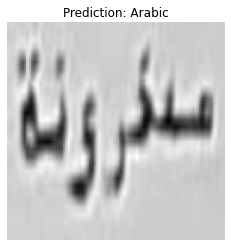

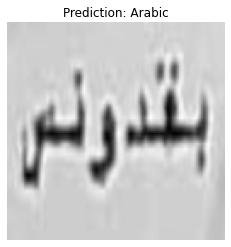

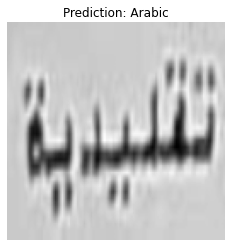

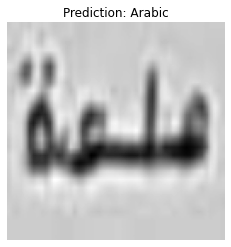

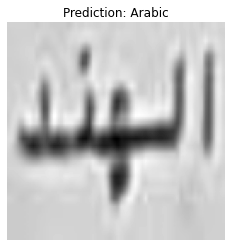

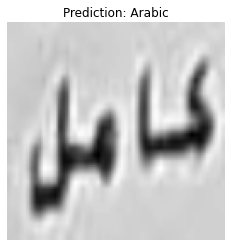

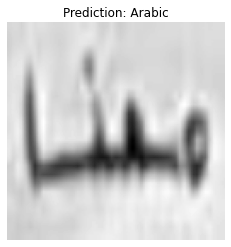

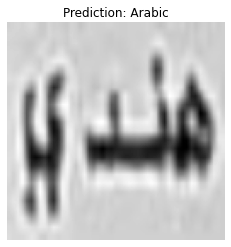

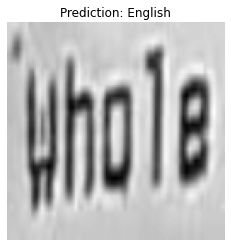

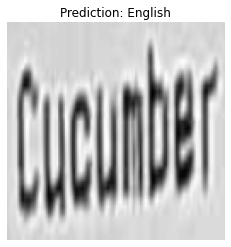

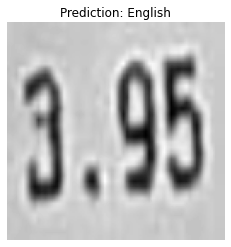

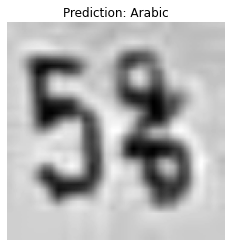

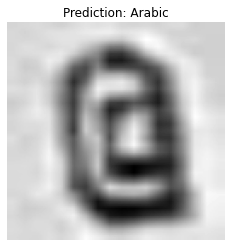

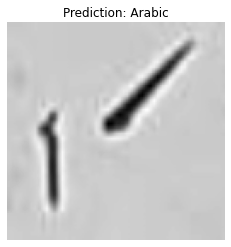

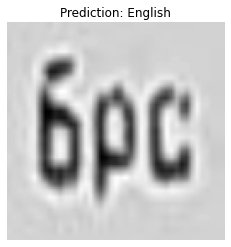

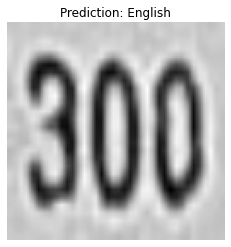

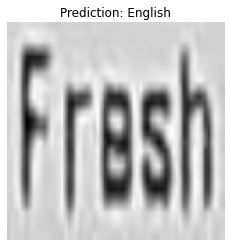

Average Inference Time: 0.0085 seconds
Accuracy: 82.35%


In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import time
import matplotlib.pyplot as plt

def get_label(file_name):
    if file_name.startswith('a'):
        return 1  # Arabic label
    else:
        return 0  # English label

def get_images_in_folder(folder_path):
    image_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            image_files.append(file_name)
    return image_files

def get_image_path(folder_path, file_name):
    return os.path.join(folder_path, file_name)

def calculate_accuracy(predictions, labels):
    predicted_classes = np.argmax(predictions, axis=1)
    correct_predictions = np.equal(predicted_classes, labels)
    accuracy = np.mean(correct_predictions)
    return accuracy

def run_inference(model_path, folder_path, device):
    output_encoder = {
        0: 'English',
        1: 'Arabic'
    }

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    images = get_images_in_folder(folder_path)
    num_images = len(images)
    total_inference_time = 0.0
    predictions = []
    labels = []

    # Set the device for inference
    if device == 'cpu':
        os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Use CPU
        print('Using CPU for inference.')
    elif device == 'gpu':
        print('Using GPU for inference.')

    for image_name in images:
        image_path = get_image_path(folder_path, image_name)
        image = cv2.imread(image_path, 0)  # Read as grayscale
        image = cv2.resize(image, (128, 128))

        # Apply transformations
        norm_stat = {"mean": (0.7511), "std": (0.1875)}
        test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(**norm_stat),
        ])
        image = test_transform(image)

        # Add batch dimension and convert to numpy array
        image = np.expand_dims(image.numpy(), axis=0)

        # Set the image as input to the TFLite model
        interpreter.set_tensor(input_details[0]['index'], image)

        # Run inference and measure time
        start_time = time.time()
        interpreter.invoke()
        inference_time = time.time() - start_time
        total_inference_time += inference_time

        # Get the output tensor
        output_tensor = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_tensor)
        labels.append(get_label(image_name))

        # Process the output
        predicted_class = output_encoder[np.argmax(output_tensor)]

        # Display image and prediction
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

    average_inference_time = total_inference_time / num_images
    predictions = np.concatenate(predictions)
    labels = np.array(labels)
    accuracy = calculate_accuracy(predictions, labels)

    print(f"Average Inference Time: {average_inference_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.2%}")


# Specify the paths and settings
model_path = "LeViT.tflite"
folder_path = "latest samples"
device = 'cpu'  # Change to 'cpu' to use CPU for inference

# Run inference
run_inference(model_path, folder_path, device)


In [10]:
import os
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import time

def get_label(file_name):
    if file_name.startswith('a'):
        return 1  # Arabic label
    else:
        return 0  # English label

def get_images_in_folder(folder_path):
    image_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            image_files.append(file_name)
    return image_files

def get_image_path(folder_path, file_name):
    return os.path.join(folder_path, file_name)

def calculate_accuracy(predictions, labels):
    predicted_classes = np.argmax(predictions, axis=1)
    correct_predictions = np.equal(predicted_classes, labels)
    accuracy = np.mean(correct_predictions)
    return accuracy

def run_inference(model_path, folder_path, device):
    output_encoder = {
        0: 'English',
        1: 'Arabic'
    }

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    images = get_images_in_folder(folder_path)
    num_images = len(images)
    total_inference_time = 0.0
    predictions = []
    labels = []

    # Set the device for inference
    if device == 'cpu':
        os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Use CPU
        print('Using CPU for inference.')
    elif device == 'gpu':
        print('Using GPU for inference.')

    for image_name in images:
        image_path = get_image_path(folder_path, image_name)
        image = cv2.imread(image_path, 0)  # Read as grayscale
        image = cv2.resize(image, (128, 128))

        # Apply transformations
        norm_stat = {"mean": (0.7511), "std": (0.1875)}
        test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(**norm_stat),
        ])
        image = test_transform(image)

        # Add batch dimension and convert to numpy array
        image = np.expand_dims(image.numpy(), axis=0)

        # Set the image as input to the TFLite model
        interpreter.set_tensor(input_details[0]['index'], image)

        # Run inference and measure time
        start_time = time.time()
        interpreter.invoke()
        inference_time = time.time() - start_time
        total_inference_time += inference_time

        # Get the output tensor
        output_tensor = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_tensor)
        labels.append(get_label(image_name))

        # Process the output
        predicted_class = output_encoder[np.argmax(output_tensor)]
        accuracy = calculate_accuracy(output_tensor, get_label(image_name))

        # Calculate frames per second (FPS)
        fps = 1 / inference_time

        # Print image information and results
        print(f"Image: {image_name}")
        print(f"Prediction: {predicted_class}")
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Inference Time: {inference_time:.4f} seconds")
        print(f"FPS: {fps:.2f}")

    average_inference_time = total_inference_time / num_images
    predictions = np.concatenate(predictions)
    labels = np.array(labels)
    accuracy = calculate_accuracy(predictions, labels)
    average_fps = 1 / average_inference_time

    print(f"\nAverage Inference Time: {average_inference_time:.4f} seconds")
    print(f"Average FPS: {average_fps:.2f}")
    print(f"Accuracy: {accuracy:.2%}")


# Specify the paths and settings
model_path = "LeViT.tflite"
folder_path = "latest samples"
device = 'cpu'  # Change to 'cpu' to use CPU for inference

# Run inference
run_inference(model_path, folder_path, device)


Using CPU for inference.
Image: arabic 3.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0080 seconds
FPS: 124.92
Image: arabic1.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0100 seconds
FPS: 100.00
Image: arabic2.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0110 seconds
FPS: 90.92
Image: arabic4.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0090 seconds
FPS: 111.10
Image: arabic5.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0110 seconds
FPS: 90.89
Image: arabic6.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0080 seconds
FPS: 125.01
Image: arabic7.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0100 seconds
FPS: 100.01
Image: arabic8.jpg
Prediction: Arabic
Accuracy: 100.00%
Inference Time: 0.0090 seconds
FPS: 111.10
Image: english1.jpg
Prediction: English
Accuracy: 100.00%
Inference Time: 0.0070 seconds
FPS: 142.86
Image: english2.jpg
Prediction: English
Accuracy: 100.00%
Inference Time: 0.0070 se